In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
import random as rn

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

from tensorflow.keras import Model
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import Xception


In [ ]:
!unzip gdrive/My\ Drive/data/AzatikDataset3.zip

Archive:  gdrive/My Drive/data/AzatikDataset3.zip
   creating: AzatikDataset2/
   creating: AzatikDataset2/Celup/
  inflating: AzatikDataset2/Celup/1.jpg  
  inflating: AzatikDataset2/Celup/10.jpg  
  inflating: AzatikDataset2/Celup/11.jpg  
  inflating: AzatikDataset2/Celup/12.jpg  
  inflating: AzatikDataset2/Celup/13.jpg  
  inflating: AzatikDataset2/Celup/14.jpg  
  inflating: AzatikDataset2/Celup/15.jpg  
  inflating: AzatikDataset2/Celup/16.jpg  
  inflating: AzatikDataset2/Celup/17.jpg  
  inflating: AzatikDataset2/Celup/18.jpg  
  inflating: AzatikDataset2/Celup/19.jpg  
  inflating: AzatikDataset2/Celup/2.jpg  
  inflating: AzatikDataset2/Celup/20.jpg  
  inflating: AzatikDataset2/Celup/21.jpg  
  inflating: AzatikDataset2/Celup/22.jpg  
  inflating: AzatikDataset2/Celup/23.jpg  
  inflating: AzatikDataset2/Celup/24.jpg  
  inflating: AzatikDataset2/Celup/25.jpg  
  inflating: AzatikDataset2/Celup/26.jpg  
  inflating: AzatikDataset2/Celup/27.jpg  
  inflating: AzatikDataset2/

In [ ]:
import os
import numpy as np
import shutil
import random

source_path = 'AzatikDataset2/' 
labels = ['Tambal', 'Parang','Megamendung','Celup','Cendrawasih']

val_ratio = 0.15
test_ratio = 0.05

os.makedirs('traintestval')

root_path = 'traintestval/'

os.makedirs(os.path.join(root_path, 'training'))
os.makedirs(os.path.join(root_path, 'testing'))
os.makedirs(os.path.join(root_path, 'validation'))

train_path = 'traintestval/training/'
test_path = 'traintestval/testing/'
val_path = 'traintestval/validation/'

for label in labels:
    os.makedirs(os.path.join(train_path, label))
    os.makedirs(os.path.join(test_path, label))
    os.makedirs(os.path.join(val_path, label))

# Creating partitions of the data after shuffeling
    src = source_path + label # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
          shutil.copy(name, train_path + label)

    for name in val_FileNames:
          shutil.copy(name, val_path + label)

    for name in test_FileNames:
          shutil.copy(name, test_path + label)

In [ ]:
source_path = 'AzatikDataset2/'
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(source_path).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=10, 
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator( rescale = 1/255 )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=3, 
                                                                class_mode='categorical',
                                                                target_size=(150, 150),
                                                                shuffle=True)
  
  ### END CODE HERE
  return train_generator, validation_generator

In [ ]:
train_dir = train_path
validation_dir = val_path #input path to VALIDATIon
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 200 images belonging to 5 classes.
Found 35 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))

Found 200 files belonging to 5 classes.


In [ ]:
class_names = train_dataset.class_names

print(class_names)

['Celup', 'Cendrawasih', 'Megamendung', 'Parang', 'Tambal']


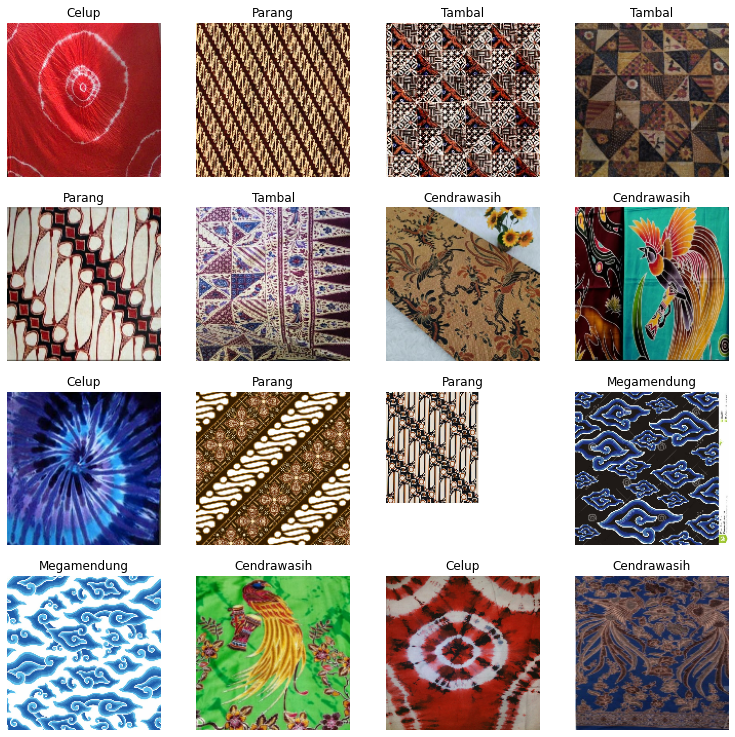

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
import random as rn

plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (3,3),activation ='relu', input_shape = (150,150,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(512, Activation('relu')))

  model.add(Dropout(0.1))
  model.add(Dense(5, activation = "softmax"))

  model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [ ]:
from tensorflow.keras.optimizers import Adam
model = create_model()

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
20/20 [==============================] - 21s 1s/step - loss: 1.6458 - accuracy: 0.2400 - val_loss: 1.4489 - val_accuracy: 0.4000


KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import Xception

In [ ]:
base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False
  )

base_model.trainable = False

base_model.summary()

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))

x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(510, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(inputs, outputs)

model.summary()

# model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator,
                    verbose = 1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
c
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
image_labels = train_generator.class_indices.keys()
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  classes = model2.predict(images, batch_size=10) #proba = model2.predict(images)[0]
  plt.imshow(img)
  plt.show()
  print(fn)
  print(classes)
  for (imge, pers) in zip(image_labels, Classes):
    print("{}: {:.2f}%".format(imge, pers * 100))